# Difference in Difference Analysis

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import statsmodels.api as sm
from patsy import dmatrix

final_dataset = pd.read_csv("/Users/alina/Desktop/final_dataset.csv")
final_dataset.head()

,County_FIPS_x,County,state_FIPS,State,pop_Year,pop_Population,pop_merge_indicator,pov_poverty_rate_percent,pov_merge_indicator,minc_median_income_USD_2021,...,FIPS|YEAR,County_FIPS_y,mort_year,mort_overdose_deaths,mort_merge_indicator,predicted_overdose_deaths_stochastic,_merge,pop_log_population,grams_morphine_per_cap,overdose_deaths_per_cap
0,1001,AUTAUGA,1,AL,2021,59203,both,10.7,both,"66,444",...,01001|2006,NaN,NaN,12.184398,Random Forest Predicted Values,12.184398,both,10.988727,0.288846,0.000203
1,1001,AUTAUGA,1,AL,2021,59203,both,10.7,both,"66,444",...,01001|2007,NaN,NaN,11.447327,Random Forest Predicted Values,11.447327,both,10.988727,0.323596,0.000186
2,1001,AUTAUGA,1,AL,2021,59203,both,10.7,both,"66,444",...,01001|2008,NaN,NaN,12.359647,Random Forest Predicted Values,12.359647,both,10.988727,0.367991,0.000203
3,1001,AUTAUGA,1,AL,2021,59203,both,10.7,both,"66,444",...,01001|2009,NaN,NaN,13.375727,Random Forest Predicted Values,13.375727,both,10.988727,0.412844,0.000220
4,1001,AUTAUGA,1,AL,2021,59203,both,10.7,both,"66,444",...,01001|2010,NaN,NaN,11.336020,Random Forest Predicted Values,11.336020,both,10.988727,0.442263,0.000186


## Data Preparation

In [2]:
def add_policy_year_break(ax, break_year_start, break_year_end):
    ax.axvspan(
        break_year_start,
        break_year_end,
        color="white",
        zorder=2,
        edgecolor=None,
        alpha=1.0,
    )
    return ax


def prepare_data(data, states, start_year, end_year):
    filtered_data = data[
        (data["opioid_YEAR"] >= start_year)
        & (data["opioid_YEAR"] <= end_year)
        & (data["State"].isin(states))
    ]
    aggregated = (
        filtered_data.groupby("opioid_YEAR")
        .agg(
            total_population=("pop_Population", "sum"),
            total_morphine=("opioid_morphine_equivalent_g", "sum"),
            total_deaths=("mort_overdose_deaths", "sum"),
        )
        .reset_index()
    )
    aggregated["log_population"] = np.log(aggregated["total_population"])
    aggregated["morphine_per_capita"] = (
        aggregated["total_morphine"] / aggregated["total_population"]
    )
    aggregated["deaths_per_capita"] = (
        aggregated["total_deaths"] / aggregated["total_population"]
    )
    return aggregated


def add_predictions(data, y_var):
    spline_basis = dmatrix(
        "bs(opioid_YEAR, degree=3, df=4)", data=data, return_type="dataframe"
    )
    model = sm.OLS(
        data[y_var],
        sm.add_constant(pd.concat([spline_basis, data["log_population"]], axis=1)),
    ).fit()
    predictions = model.get_prediction(
        sm.add_constant(pd.concat([spline_basis, data["log_population"]], axis=1))
    ).summary_frame()
    data[f"{y_var}_predicted"] = predictions["mean"]
    data[f"{y_var}_ci_low"] = predictions["mean_ci_lower"]
    data[f"{y_var}_ci_high"] = predictions["mean_ci_upper"]
    return data

## Florida

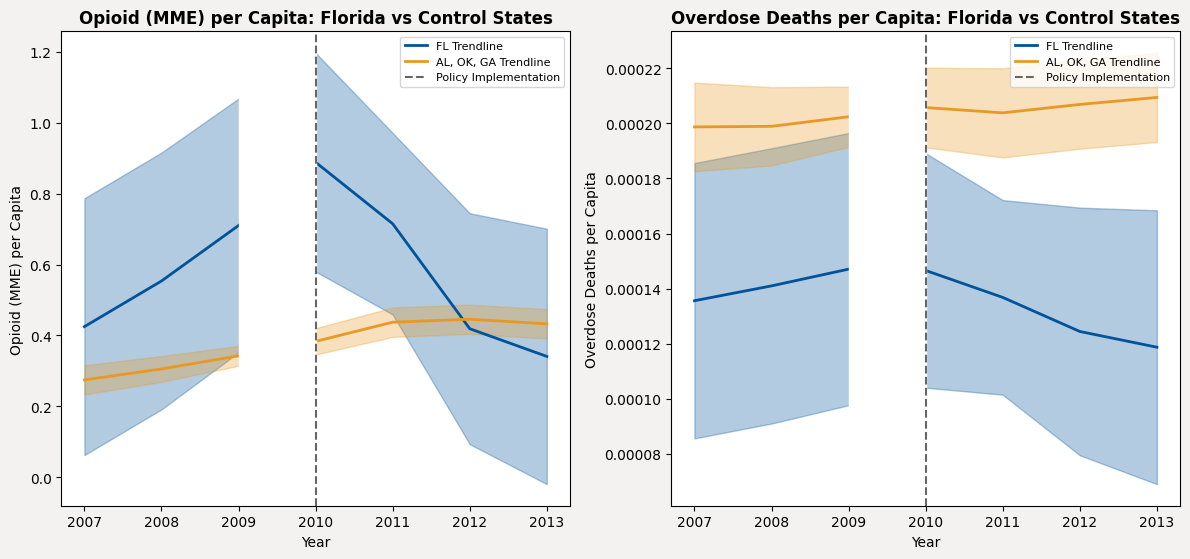

In [3]:
def create_did_charts_florida(final_dataset, control_states):
    florida_data = prepare_data(final_dataset, ["FL"], 2007, 2013)
    florida_data = add_predictions(florida_data, "morphine_per_capita")
    florida_data = add_predictions(florida_data, "deaths_per_capita")

    control_data = prepare_data(final_dataset, control_states, 2007, 2013)
    control_data = add_predictions(control_data, "morphine_per_capita")
    control_data = add_predictions(control_data, "deaths_per_capita")

    duke_colors = {
        "blue": "#00539B",
        "gray": "#666666",
        "orange": "#E89923",
        "background": "#F3F2F1",
    }

    fig = plt.figure(figsize=(12, 6), facecolor=duke_colors["background"])
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    ax1 = fig.add_subplot(spec[0])
    ax1.plot(
        florida_data["opioid_YEAR"],
        florida_data["morphine_per_capita_predicted"],
        color=duke_colors["blue"],
        label="FL Trendline",
        linewidth=2,
    )
    ax1.fill_between(
        florida_data["opioid_YEAR"],
        florida_data["morphine_per_capita_ci_low"],
        florida_data["morphine_per_capita_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    ax1.plot(
        control_data["opioid_YEAR"],
        control_data["morphine_per_capita_predicted"],
        color=duke_colors["orange"],
        label="AL, OK, GA Trendline",
        linewidth=2,
    )
    ax1.fill_between(
        control_data["opioid_YEAR"],
        control_data["morphine_per_capita_ci_low"],
        control_data["morphine_per_capita_ci_high"],
        color=duke_colors["orange"],
        alpha=0.3,
    )
    ax1 = add_policy_year_break(ax1, 2009, 2010)
    ax1.axvline(
        x=2010,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
        label="Policy Implementation",
    )
    ax1.set_title(
        "Opioid (MME) per Capita: Florida vs Control States",
        fontsize=12,
        weight="bold",
    )
    ax1.set_xlabel("Year", fontsize=10)
    ax1.set_ylabel("Opioid (MME) per Capita", fontsize=10)
    ax1.legend(loc="upper right", fontsize=8, framealpha=0.8)

    ax2 = fig.add_subplot(spec[1])
    ax2.plot(
        florida_data["opioid_YEAR"],
        florida_data["deaths_per_capita_predicted"],
        color=duke_colors["blue"],
        label="FL Trendline",
        linewidth=2,
    )
    ax2.fill_between(
        florida_data["opioid_YEAR"],
        florida_data["deaths_per_capita_ci_low"],
        florida_data["deaths_per_capita_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    ax2.plot(
        control_data["opioid_YEAR"],
        control_data["deaths_per_capita_predicted"],
        color=duke_colors["orange"],
        label="AL, OK, GA Trendline",
        linewidth=2,
    )
    ax2.fill_between(
        control_data["opioid_YEAR"],
        control_data["deaths_per_capita_ci_low"],
        control_data["deaths_per_capita_ci_high"],
        color=duke_colors["orange"],
        alpha=0.3,
    )
    ax2 = add_policy_year_break(ax2, 2009, 2010)
    ax2.axvline(
        x=2010,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
        label="Policy Implementation",
    )
    ax2.set_title(
        "Overdose Deaths per Capita: Florida vs Control States",
        fontsize=12,
        weight="bold",
    )
    ax2.set_xlabel("Year", fontsize=10)
    ax2.set_ylabel("Overdose Deaths per Capita", fontsize=10)
    ax2.legend(loc="upper right", fontsize=8, framealpha=0.8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


control_states = ["AL", "OK", "GA"]
create_did_charts_florida(final_dataset=final_dataset, control_states=control_states)

## Washington

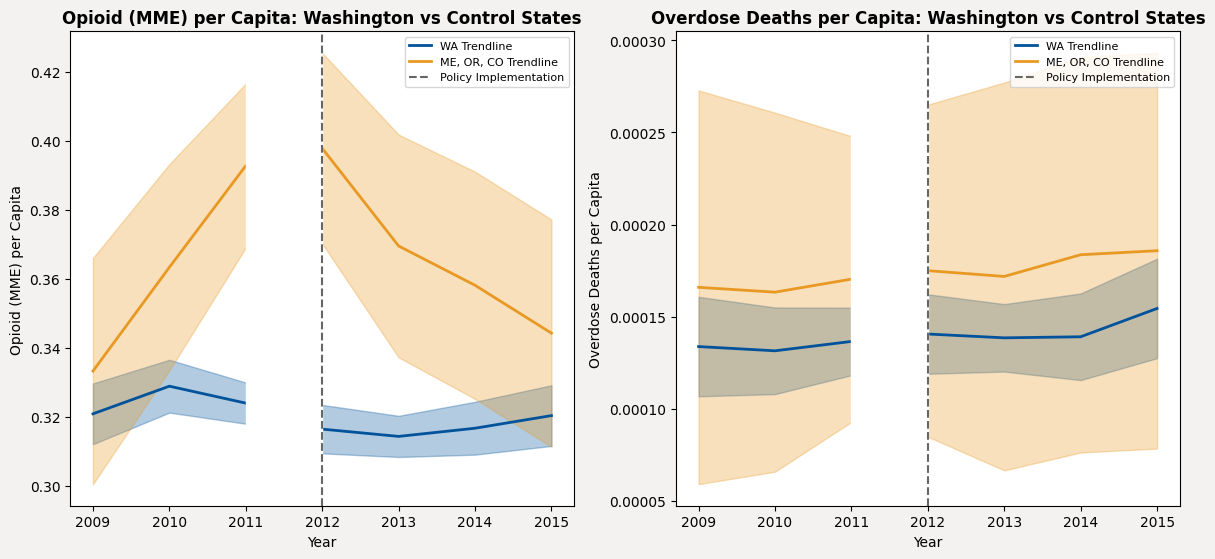

In [4]:
def create_did_charts_washington(final_dataset, control_states):
    washington_data = prepare_data(final_dataset, ["WA"], 2009, 2015)
    washington_data = add_predictions(washington_data, "morphine_per_capita")
    washington_data = add_predictions(washington_data, "deaths_per_capita")

    control_data = prepare_data(final_dataset, control_states, 2009, 2015)
    control_data = add_predictions(control_data, "morphine_per_capita")
    control_data = add_predictions(control_data, "deaths_per_capita")

    duke_colors = {
        "blue": "#00539B",
        "gray": "#666666",
        "orange": "#E89923",
        "background": "#F3F2F1",
    }

    fig = plt.figure(figsize=(12, 6), facecolor=duke_colors["background"])
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    ax1 = fig.add_subplot(spec[0])
    ax1.plot(
        washington_data["opioid_YEAR"],
        washington_data["morphine_per_capita_predicted"],
        color=duke_colors["blue"],
        label="WA Trendline",
        linewidth=2,
    )
    ax1.fill_between(
        washington_data["opioid_YEAR"],
        washington_data["morphine_per_capita_ci_low"],
        washington_data["morphine_per_capita_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    ax1.plot(
        control_data["opioid_YEAR"],
        control_data["morphine_per_capita_predicted"],
        color=duke_colors["orange"],
        label="ME, OR, CO Trendline",
        linewidth=2,
    )
    ax1.fill_between(
        control_data["opioid_YEAR"],
        control_data["morphine_per_capita_ci_low"],
        control_data["morphine_per_capita_ci_high"],
        color=duke_colors["orange"],
        alpha=0.3,
    )
    ax1 = add_policy_year_break(ax1, 2011, 2012)
    ax1.axvline(
        x=2012,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
        label="Policy Implementation",
    )
    ax1.set_title(
        "Opioid (MME) per Capita: Washington vs Control States",
        fontsize=12,
        weight="bold",
    )
    ax1.set_xlabel("Year", fontsize=10)
    ax1.set_ylabel("Opioid (MME) per Capita", fontsize=10)
    ax1.legend(loc="upper right", fontsize=8, framealpha=0.8)

    ax2 = fig.add_subplot(spec[1])
    ax2.plot(
        washington_data["opioid_YEAR"],
        washington_data["deaths_per_capita_predicted"],
        color=duke_colors["blue"],
        label="WA Trendline",
        linewidth=2,
    )
    ax2.fill_between(
        washington_data["opioid_YEAR"],
        washington_data["deaths_per_capita_ci_low"],
        washington_data["deaths_per_capita_ci_high"],
        color=duke_colors["blue"],
        alpha=0.3,
    )
    ax2.plot(
        control_data["opioid_YEAR"],
        control_data["deaths_per_capita_predicted"],
        color=duke_colors["orange"],
        label="ME, OR, CO Trendline",
        linewidth=2,
    )
    ax2.fill_between(
        control_data["opioid_YEAR"],
        control_data["deaths_per_capita_ci_low"],
        control_data["deaths_per_capita_ci_high"],
        color=duke_colors["orange"],
        alpha=0.3,
    )
    ax2 = add_policy_year_break(ax2, 2011, 2012)
    ax2.axvline(
        x=2012,
        color=duke_colors["gray"],
        linestyle="--",
        linewidth=1.5,
        label="Policy Implementation",
    )
    ax2.set_title(
        "Overdose Deaths per Capita: Washington vs Control States",
        fontsize=12,
        weight="bold",
    )
    ax2.set_xlabel("Year", fontsize=10)
    ax2.set_ylabel("Overdose Deaths per Capita", fontsize=10)
    ax2.legend(loc="upper right", fontsize=8, framealpha=0.8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


control_states = ["ME", "OR", "CO"]
create_did_charts_washington(final_dataset=final_dataset, control_states=control_states)